# Comparison measurements and theory

# CURRENT BIG BIG PROBLEMS

Looks good but is probably wrong. I have here removed the A from the simulation plot because i felt like after demodulation it should be gone. Also, i haven't considered the absorption and trasnfer through the photodiode. gotta dig into this.

Reminder of the theory :

$$M_{pump} = R_{op} M_0 sin(\theta) cos(\theta) \delta \sqrt{2}\frac{\Gamma sin(\omega t) - \Delta cos(\omega t)}{\Gamma (\Gamma^2 + \Delta^2 + 2 \delta^2)} + R_{op} M_0 cos^2(\theta) \frac{\Gamma^2 + \Delta^2}{\Gamma(\Gamma^2+\Delta^2+2\delta^2)}$$

In order to compute the dispersive and absorptive behavior of the medium, we need to extract the susceptibility here.

Taking the AC part of $M_{pump}$, we get:

$$M_{pump,AC} = R_{op} M_0 sin(\theta) cos(\theta) \delta \sqrt{2}\frac{\Gamma sin(\omega t) - \Delta cos(\omega t)}{\Gamma (\Gamma^2 + \Delta^2 + 2 \delta^2)}$$

One can notice that :
$$\Gamma sin(\omega t) - \Delta cos(\omega t) = \Im{((\Gamma-i\Delta)e^{i \omega t})}$$

We know the general form :
$$M_{AC} = A \Im{(\Chi(\Delta)e^{i \omega t})}$$
By identification :
$$A = R_{op} M_0 sin(\theta) cos(\theta) \delta \sqrt{2}$$
$$\Chi(\Delta) = \frac{\Gamma - i\Delta}{\Gamma (\Gamma^2 + \Delta^2 + 2 \delta^2)}$$

Because of the signal measured is with an MFLI, the DC part plays no role and the $e^{i \omega t}$ is removed to get the X and Y  signals.

Quick notes :

The FWHM seems to fit if and only if the R_op is removed from the $\Gamma_{tot}$, and with a lower field.
It is good to remind that the lorentzian absorptive profile is :
$$\Re{(\Chi)} = \frac{\Gamma_{tot}}{\Gamma_{tot} (\Gamma_{tot}^2 + \Delta^2 + 2\delta^2)} = \frac{1}{\Gamma_{tot}^2 + \Delta^2 + 2\delta^2}$$
Hence, the FWHM is given by:
$$FWHM(\Chi(\Delta)) = 2\sqrt{\Gamma_{tot}^2 + 2\delta^2}$$

Orders of magntiude are weirdly fitting the data if i remove A from the simulation (i assumed it wasn't incorrect because of the demodulation, which offsets the DC, but might be wrong)
additionnally, this didn't take into account the transmission measurement (just the magnetization), so orders of magnitude off. gotta add the A back and properly compute the transmission of light, then the demodulation. 
My current question is regarding how does the real and imaginary part compute in the transmission ?

## Updates 25.11.2025

Transmission before/after cell measured again, 1.2mW before cell, 0.63mW after cell, with or without RF doesn't change these values (must expect less than 0.01mW of difference in absorption then).

RF power measured properly, with the SR560 low noise pre amplifier. MFLI goes in SR560, SR560 goes to coil and oscilloscope, reading on oscilloscope in V /100 /0.05 gives the A. We measured 9.3mV, hence 1.86mA. This gives us a $|B_{RF}| = 1.46 \mu T$

In [1]:
## Imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from IPython.display import display, HTML
from scipy.constants import *

## Simulation

In [4]:
## constants
sigma = 1.082e-13 #m^2 from Table 7, [2]
mu_B = 9.2740100657e-24 # J/T Bohr Magneton
g_F = 0.5006
mu_eff = g_F * mu_B  # g_F depends on hyperfine level (±1/2 for Rb-87)
gamma = 7e9             # Gyromagnetic ratio (Hz/T)
Gamma_natural = 36.10e6 # Natural linewidth (Hz)
I_sat = 44.84              # Saturation intensity (W/m²)
P_sat = 35.2e-3 # for 1mm beam diameter

## Functions

def R_op(I):
    return Gamma_natural * I / (I + I_sat)

def compute_M_pump(t, R_op_val, M0, delta, theta, Gamma, omega, omega_0):
    Gamma_tot = R_op_val + Gamma
    Delta = omega - omega_0  # Detuning

    numerator_My = Gamma_tot * np.sin(omega * t) - Delta * np.cos(omega * t)
    denominator = Gamma_tot * (Gamma_tot**2 + Delta**2 + 2 * delta**2)

    My = R_op_val * M0 * delta * np.cos(theta) * np.sqrt(2) * numerator_My / denominator
    Mz = R_op_val * M0 * np.cos(theta) * (Gamma_tot**2 + Delta**2) / denominator

    M_pump = np.sin(theta) * My + np.cos(theta) * Mz

    # Compute oscillation amplitude
    amplitude = (np.max(M_pump) - np.min(M_pump))
    DC_val = np.mean(M_pump)

    return M_pump, amplitude, DC_val

def compute_M_pump_instant(t, R_op_val, M0, delta, theta, Gamma, omega, omega_0):
    Gamma_tot = R_op_val + Gamma
    Delta = omega - omega_0  # Detuning

    numerator_My = Gamma_tot - Delta
    denominator = Gamma_tot * (Gamma_tot**2 + Delta**2 + 2 * delta**2)

    My = R_op_val * M0 * delta * np.cos(theta) * np.sqrt(2) * numerator_My / denominator
    Mz = R_op_val * M0 * np.cos(theta) * (Gamma_tot**2 + Delta**2) / denominator

    M_pump = np.sin(theta) * My + np.cos(theta) * Mz

    # Compute oscillation amplitude
    amplitude = (np.max(M_pump) - np.min(M_pump))
    DC_val = np.mean(M_pump)

    return M_pump, amplitude, DC_val


## Beginning of the 'High Sensitivity Magnetometers'

In [5]:
theta_rf = 0
theta_B = np.deg2rad(45)
phi_B = 0
B_rf = 1.46e-6 #let's assume B_rf // k // x
gamma_F = 7e9 #Hz/T
gamma = 5e3 #relaxation
P_0 = 1.2e-3
gamma_pump = gamma*P_0/P_sat
S_infty = 1/2
T = 273.15 + 80
n = (1/T)*10**(21.866+4.312-4040/T) * 10**6       

S0 = S_infty*(gamma_pump/(gamma_pump+gamma))

def compute_S_k(theta_rf, theta_B, phi_B, omega_0, B_rf,omega,t):
    delta_omega = omega-omega_0
    Omega = gamma_F*B_rf
    Omega_xp = Omega*np.sin(phi_B)*np.sin(theta_rf)
    Omega_yp = -Omega*np.sin(theta_B)*np.cos(theta_rf) - Omega*np.cos(theta_B)*np.cos(phi_B)*np.sin(theta_rf)

    u_ss = ((-delta_omega*Omega_xp + gamma*Omega_yp)/(delta_omega**2+gamma**2+Omega_xp**2+Omega_yp**2))*S0*np.cos(theta_B)
    v_ss = ((-delta_omega*Omega_yp - gamma*Omega_xp)/(delta_omega**2+gamma**2+Omega_xp**2+Omega_yp**2))*S0*np.cos(theta_B)
    w_ss = ((delta_omega**2 + gamma**2)/(delta_omega**2+gamma**2+Omega_xp**2+Omega_yp**2))*S0*np.cos(theta_B)

    S_DC = w_ss*np.cos(theta_B)
    S_IP = -v_ss*np.sin(theta_B)
    S_QU = -u_ss*np.sin(theta_B)

    S_k = S_DC + S_IP*np.sin(omega*t) + S_QU*np.cos(omega*t)

    return S_k, S_DC, S_IP, S_QU

r_e = 2.82e-15 #m, classical electron radius
c = 299792458
f = 1/3
L = 1.5e-3 #length of the cell
#kappa = (2*r_e*c*f)/Gamma_natural * n
kappa = 0.5/L
alpha = 1  #Not sure, no value, might be the 1/137 something


def compute_P_k(P_0, theta_B, L, kappa, theta_rf, phi_B, omega_0, B_rf,omega,t):
    delta_omega = omega-omega_0
    Omega = gamma_F*B_rf
    Omega_xp = Omega*np.sin(phi_B)*np.sin(theta_rf)
    Omega_yp = -Omega*np.sin(theta_B)*np.cos(theta_rf) - Omega*np.cos(theta_B)*np.cos(phi_B)*np.sin(theta_rf)

    u_ss = ((-delta_omega*Omega_xp + gamma*Omega_yp)/(delta_omega**2+gamma**2+Omega_xp**2+Omega_yp**2))*S0*np.cos(theta_B)
    v_ss = ((-delta_omega*Omega_yp - gamma*Omega_xp)/(delta_omega**2+gamma**2+Omega_xp**2+Omega_yp**2))*S0*np.cos(theta_B)
    w_ss = ((delta_omega**2 + gamma**2)/(delta_omega**2+gamma**2+Omega_xp**2+Omega_yp**2))*S0*np.cos(theta_B)


    P_DC = P_0 - P_0*kappa*L + P_0*kappa*L*alpha*w_ss*np.cos(theta_B)
    P_IP = -P_0*kappa*L*alpha*v_ss*np.sin(theta_B)
    P_QU = -P_0*kappa*L*alpha*u_ss*np.sin(theta_B)

    P_k = P_DC + P_IP*np.sin(omega*t) + P_QU*np.cos(omega*t)

    return P_k, P_DC, P_IP, P_QU


In [6]:
B_0 = 163000/gamma_F
omega_0 = gamma_F*B_0
omega = np.linspace(130000,200000,1000000)
t = 1

signal, signal_DC, signal_IP, signal_QU = compute_S_k(theta_rf, theta_B, phi_B, omega_0, B_rf,omega,t)

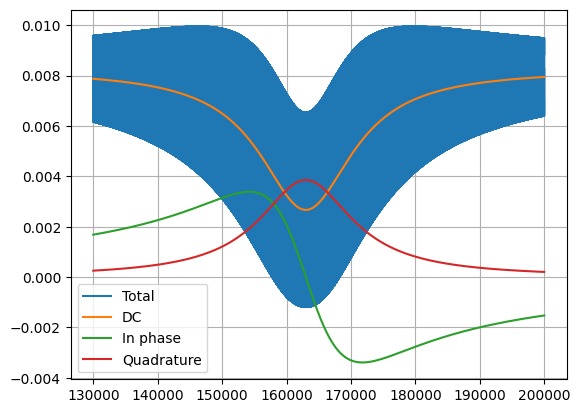

In [7]:
plt.clf()
plt.plot(omega,signal, label='Total')
plt.plot(omega, signal_DC, label ='DC')
plt.plot(omega, signal_IP, label='In phase')
plt.plot(omega, signal_QU, label = 'Quadrature')
plt.legend()
plt.grid(True, which='both')
plt.show()

In [8]:
P_signal, P_DC, P_IP, P_QU = compute_P_k(P_0, theta_B, L, kappa, theta_rf, phi_B, omega_0, B_rf,omega,t)

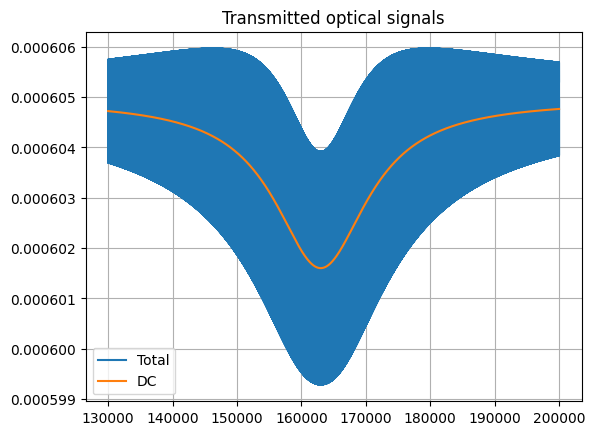

In [9]:
plt.clf()
plt.title('Transmitted optical signals')
plt.plot(omega,P_signal, label='Total')
plt.plot(omega, P_DC, label ='DC')
plt.legend()
plt.grid(True, which='both')
plt.show()

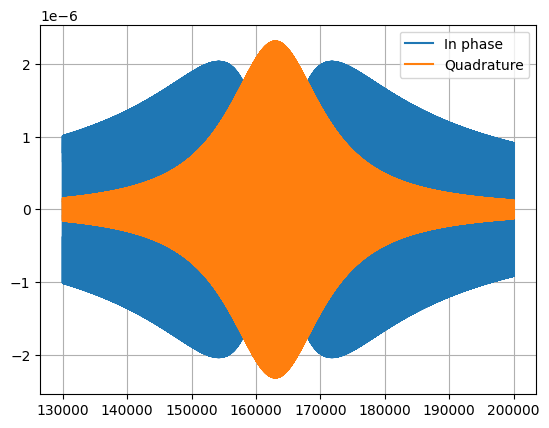

In [10]:
plt.clf()
plt.plot(omega, P_IP*np.sin(omega*t), label='In phase')
plt.plot(omega, P_QU*np.cos(omega*t), label = 'Quadrature')
plt.legend()
plt.grid(True, which='both')
plt.show()

## Here add demodulation on top of the P signal

In [38]:
import numpy as np

# -------------------------------------------
# Parameters
# -------------------------------------------
fs = 20e3            # sampling rate
tau_dwell = 5e-3      # dwell time per frequency point
N_time = int(tau_dwell * fs)
t_block = np.arange(N_time) / fs

# Your sweep frequencies (rad/s)
omega_sweep = np.linspace(130e3, 200e3, 2000) * 2*np.pi

# Allocate arrays for demod outputs
X = np.zeros(len(omega_sweep))
Y = np.zeros(len(omega_sweep))

# -------------------------------------------
# Sweep loop
# -------------------------------------------
for i, omega in enumerate(omega_sweep):

    # steady-state values at this frequency
    P_k, P_DC, P_IP, P_QU = compute_P_k(
        P_0, theta_B, L, kappa, theta_rf, phi_B, omega_0,
        B_rf, omega, t=0
    )

    # build time signal
    P_t = (P_DC +
           P_IP * np.sin(omega * t_block) +
           P_QU * np.cos(omega * t_block))

    # reference signals
    ref_cos = np.cos(omega * t_block)
    ref_sin = np.sin(omega * t_block)

    # Lock-in integration (simple averaging)
    X[i] = 2*np.mean(P_t * ref_cos)
    Y[i] = 2*np.mean(P_t * ref_sin)

# X and Y now contain the same values the MFLI sweeper would output

In [11]:
import numpy as np
from scipy.signal import butter, filtfilt

def iq_demodulate(t, signal, f_demod, lp_cutoff=None, order=4):
    """
    Perform IQ (X/Y) demodulation of a real signal.

    Parameters
    ----------
    t : array
        Time vector.
    signal : array
        Input signal s(t).
    f_demod : float
        Demodulation frequency in Hz.
    lp_cutoff : float, optional
        Low-pass filter cutoff frequency (Hz).
        If None, no filtering is done.
    order : int
        Filter order.

    Returns
    -------
    X : array
        In-phase demodulated component.
    Y : array
        Quadrature demodulated component.
    """
    # Ensure input is numpy array
    t = np.asarray(t)
    signal = np.asarray(signal)

    # Reference oscillators
    cos_ref = np.cos(2 * np.pi * f_demod * t)
    sin_ref = np.sin(2 * np.pi * f_demod * t)

    # Multiply (mixing stage)
    X_raw = signal * cos_ref
    Y_raw = signal * sin_ref

    # Apply low-pass filter (optional)
    if lp_cutoff is not None:
        fs = 1 / (t[1] - t[0])  # sample rate
        b, a = butter(order, lp_cutoff / (fs / 2), btype='low')
        X = filtfilt(b, a, X_raw)
        Y = filtfilt(b, a, Y_raw)
    else:
        X, Y = X_raw, Y_raw

    return X, Y

In [ ]:
import numpy as np
from scipy.signal import butter, filtfilt

def demodulate_continuous_sweep(t_continuous, f_drive_t, s_t, f_sweep_times, dwell_times,
                                ref_phase=0.0, window_cycles=4, lp_cutoff=None, lp_order=4):
    """
    Demodulate a long continuous trace that was produced while the drive frequency was swept.

    Inputs:
      t_continuous : (Nt,) time array for the entire sweep
      f_drive_t    : (Nt,) instantaneous drive frequency vs time (same units as f_sweep)
      s_t          : (Nt,) continuous photodiode signal
      f_sweep_times: list of times (or time centers) where you want lock-in outputs (one per freq)
      dwell_times  : scalar or array of same length as f_sweep_times -> half-window length for averaging (s)
      ref_phase    : reference phase
      window_cycles: number of cycles of instantaneous f to average for each output (alternative to dwell_times)
      lp_cutoff    : optional global low-pass applied after mixing (Hz)
    Returns:
      X_list, Y_list arrays corresponding to f_sweep_times
    """
    Nt = len(t_continuous)
    if np.isscalar(dwell_times):
        dwell_times = np.repeat(dwell_times, len(f_sweep_times))

    X_list = np.zeros(len(f_sweep_times))
    Y_list = np.zeros(len(f_sweep_times))

    # For each requested output point take a local window around t0 and demodulate with the *local* frequency
    for i, t0 in enumerate(f_sweep_times):
        # find index of t0
        idx = np.searchsorted(t_continuous, t0)
        # define window
        half = int(np.round((dwell_times[i] / (t_continuous[1]-t_continuous[0]))/2.0))
        i0 = max(0, idx-half)
        i1 = min(Nt, idx+half)
        twin = t_continuous[i0:i1]
        s_win = s_t[i0:i1]
        # pick a reference frequency for this window (mean of f_drive_t inside window)
        f_ref = np.mean(f_drive_t[i0:i1])
        omega = 2*np.pi*f_ref
        ref_cos = np.cos(omega*twin + ref_phase)
        ref_sin = np.sin(omega*twin + ref_phase)
        X_list[i] = 2.0 * np.mean(s_win * ref_cos)
        Y_list[i] = 2.0 * np.mean(s_win * ref_sin)

    # optional low-pass smoothing of the resulting sequence
    if lp_cutoff is not None:
        fs_out = 1.0 / (f_sweep_times[1]-f_sweep_times[0])  # effective sampling along sweep points (Hz)
        nyq = fs_out/2.0
        b, a = butter(lp_order, lp_cutoff/nyq, btype='low')
        X_list = filtfilt(b,a,X_list)
        Y_list = filtfilt(b,a,Y_list)

    return X_list, Y_list


In [33]:
import numpy as np
from scipy.interpolate import interp1d

def simulate_lockin_from_PD(f_sweep, P_vs_f,
                            f_mod=1000.0,        # modulation frequency [Hz]
                            delta_f=1.0,         # modulation amplitude [Hz]
                            mod_phase=0.0,       # modulation phase [rad]
                            ref_phase=0.0,       # lock-in reference phase [rad]
                            pts_per_cycle=200,   # time samples per modulation cycle
                            cycles=3,            # cycles to simulate per sweep point
                            dwell_time=None,     # time spent at each sweep point [s], if None = cycles/f_mod
                            time_constant=None,  # sweeper time constant [s] (first-order low-pass across sweep)
                            interp_kind='cubic'  # interpolation of P_vs_f
                           ):
    """
    Simulate lock-in (X,Y) outputs from a photodiode signal P(f).

    Inputs
    ------
    f_sweep : 1D array
        Center frequencies of the sweep (Hz).
    P_vs_f : 1D array or callable
        Photodiode power as function of frequency. If array, it must be sampled on some
        frequency axis; in that case supply the corresponding array as a tuple (f_grid, P_grid).
        If callable, should accept vector frequency input and return power.
    f_mod : float
        Modulation frequency (Hz).
    delta_f : float
        Modulation amplitude (Hz). (instantaneous freq = f0 + delta_f * sin(...))
    mod_phase : float
        Phase of the modulation (rad).
    ref_phase : float
        Phase offset applied to the lock-in references (rad).
    pts_per_cycle : int
        Number of time samples per modulation cycle used to create the time series.
    cycles : int
        How many modulation cycles to simulate per sweep point (dwell time ~ cycles/f_mod).
    dwell_time : float or None
        If None, set to cycles/f_mod. Used when applying the sweeper time constant.
    time_constant : float or None
        If provided, apply a first-order low-pass (tau = time_constant) to the sequence of X and Y
        to mimic the MFLI time constant / lock-in averaging between sweep points.
    interp_kind : str
        Interpolation kind for P(f) if providing arrays ('linear','cubic',...).

    Returns
    -------
    X : 1D array
        In-phase lock-in output vs f_sweep.
    Y : 1D array
        Quadrature lock-in output vs f_sweep.
    """
    # Prepare P(f) callable
    if callable(P_vs_f):
        P_of_f = P_vs_f
    else:
        # expect tuple (f_grid, P_grid)
        try:
            f_grid, P_grid = P_vs_f
        except Exception:
            raise ValueError("If P_vs_f is not callable, pass (f_grid, P_grid).")
        P_of_f = interp1d(f_grid, P_grid, kind=interp_kind, bounds_error=False, fill_value="extrapolate")

    N = len(f_sweep)
    if dwell_time is None:
        dwell_time = cycles / f_mod
    pts = int(np.ceil(pts_per_cycle * cycles))
    t = np.linspace(0.0, cycles / f_mod, pts, endpoint=False)  # time array for one dwell

    # references (with ref_phase)
    omega = 2 * np.pi * f_mod
    ref_cos = np.cos(omega * t + ref_phase)
    ref_sin = np.sin(omega * t + ref_phase)

    X_raw = np.zeros(N, dtype=float)
    Y_raw = np.zeros(N, dtype=float)

    # loop over sweep points (vectorizable but loop is simple and robust)
    for i, f0 in enumerate(f_sweep):
        inst_freq = f0 + delta_f * np.sin(omega * t + mod_phase)   # instantaneous freq vs time
        s_t = P_of_f(inst_freq)                                     # photodiode output vs time
        # demodulate: multiply by refs and average (normalize so pure cosine amplitude A -> X = A)
        # use mean, and multiply by 2 to recover amplitude of single-tone if signal was cos()
        X_raw[i] = 2.0 * np.mean(s_t * ref_cos)
        Y_raw[i] = 2.0 * np.mean(s_t * ref_sin)

    # Apply first-order low-pass across sweep to mimic time constant (discrete exponential filter)
    if time_constant is not None and time_constant > 0:
        dt = dwell_time
        alpha = dt / (time_constant + dt)   # discrete filter coefficient
        X = np.empty_like(X_raw)
        Y = np.empty_like(Y_raw)
        X[0] = X_raw[0]
        Y[0] = Y_raw[0]
        for i in range(1, N):
            X[i] = X[i-1] + alpha * (X_raw[i] - X[i-1])
            Y[i] = Y[i-1] + alpha * (Y_raw[i] - Y[i-1])
    else:
        X, Y = X_raw, Y_raw

    return X, Y


In [ ]:
X,Y = simulate_lockin_from_PD(f_sweep=omega, P_vs_f=[omega,P_signal], f_mod=0, delta_f=1, dwell_time=0.01)

ZeroDivisionError: division by zero

array([0.00000000e+00, 5.38462077e-03, 1.07692415e-02, ...,
       5.38460462e+03, 5.38461000e+03, 5.38461538e+03])

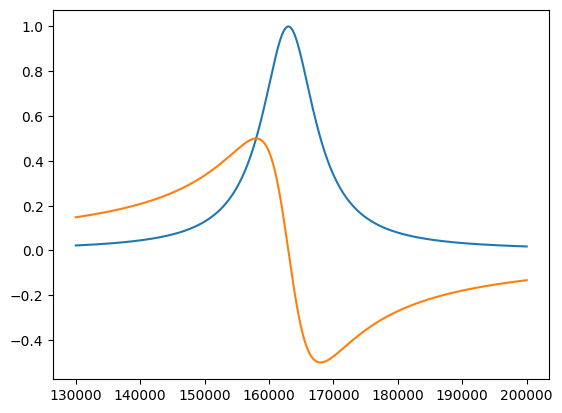

In [31]:
plt.plot(omega, X)
plt.plot(omega,Y)
plt.show()

## End of the model from High Sensitivity Magnetometers

In [ ]:
## Inputs
T = 273+80                    # Cell temperature (K)
B0 = 163e3/gamma                 # Static magnetic field (T)
B1 = 1.46e-6                # RF magnetic field (T) ESTIMATED IMPRECISELY
theta = np.deg2rad(45)     # Angle (rad)
Gamma = 5e3           # Spin relaxation rate (Hz) ESTIMATED TO FIT THE WIDTH OF THE EXPERIMENTAL CURVES
beam_diameter = 1e-3       # Beam diameter (m)
z_cell = 1.5e-3            # Cell length (m)
A_beam = np.pi * (beam_diameter / 2)**2
R = 0.568                  # Photodiode responsivity (A/W)

## Derived Quantities
n = (1/T)*10**(21.866+4.312-4040/T) * 10**6                # Vapor density
M0 = n * mu_eff                  # Max magnetization
omega_0 = gamma * B0              # Larmor frequency (rad/s)
print(omega_0)
delta = (1 / (2 * np.sqrt(2))) * gamma * B1 * np.sin(theta)  # RF coupling

## Empirical data
P_in = 1.2e-3           # Laser power [W]
P_out0 = 0.63e-3       # Transmission without RF
T0 = P_out0 / P_in
OD0 = -np.log(T0)

I_laser = P_in / A_beam
R_op = Gamma_natural * I_laser / (I_laser + I_sat)
Gamma_tot = Gamma #+ R_op
delta = (gamma * B1 / (2*np.sqrt(2))) * np.sin(theta)

# AC magnetization prefactor
A = R_op * M0 * np.sin(theta) * np.cos(theta) * delta * np.sqrt(2)
# Frequency sweep

omega = np.linspace(130000, 200000, 1000)
Delta = omega - omega_0
t=np.linspace(0,1,1000)

chi_non_complex = (Gamma_tot*np.sin(omega*t) - Delta)*np.cos(omega*t) / (Gamma_tot*(Gamma_tot**2 + Delta**2 + 2*delta**2))


M_pump_tot, _,_ = compute_M_pump_instant(t=t, R_op_val=R_op, M0=M0, delta=delta, theta=theta, Gamma=Gamma_tot,omega=omega, omega_0=omega_0)
M_pump_temp,_,_ = compute_M_pump(t=t, R_op_val=R_op, M0=M0, delta=delta, theta=theta, Gamma=Gamma_tot,omega=omega, omega_0=omega_0)

# Complex AC magnetization
chi = (Gamma_tot - 1j*Delta) / (Gamma_tot*(Gamma_tot**2 + Delta**2 + 2*delta**2))
M_AC =  A*chi

M_AC_non_complex = A*chi_non_complex

## The minus sign comes form the fact that the magnetization will orient positively and will translate into more absorption
Y_sim = -np.real(M_AC)  # absorptive (dip)
X_sim = np.imag(M_AC)   # dispersive

OD_mod_real = OD0 * (1 + np.real(M_AC)/M0)
OD_mod = OD0 * (1 + M_AC/M0)

T = P_in * np.exp(-OD_mod)
T_tot = P_in * np.exp(-M_pump_tot/M0)


163000.0


In [148]:
Gamma*Gamma/omega_0

153.37423312883436

Debugging the magnetization because it's not giving correct values according to me. Or i don't understand what's going, which is also very likely

In [ ]:
omega_vec = np.linspace(130000, 200000, 10000)
t_vec = np.linspace(0,0.001,1000)

results_raw = np.zeros((len(omega_vec), len(t_vec)))
M_pump = np.zeros(len(omega_vec))
for i,omega in enumerate(omega_vec):
    for j,t in enumerate(t_vec):
        results_raw[i, j],_,_ = compute_M_pump(t, R_op, M0, delta, theta, Gamma, omega, omega_0)
    M_pump[i] = np.max(results_raw[i,:]) - np.min(results_raw[i,:])


In [ ]:
M_pump_wtf = np.zeros(len(omega_vec))
for i in range(omega_vec):
    M_pump_wtf[i] = np.std(results_raw[i,:])

In [127]:
omega_0

163000.0

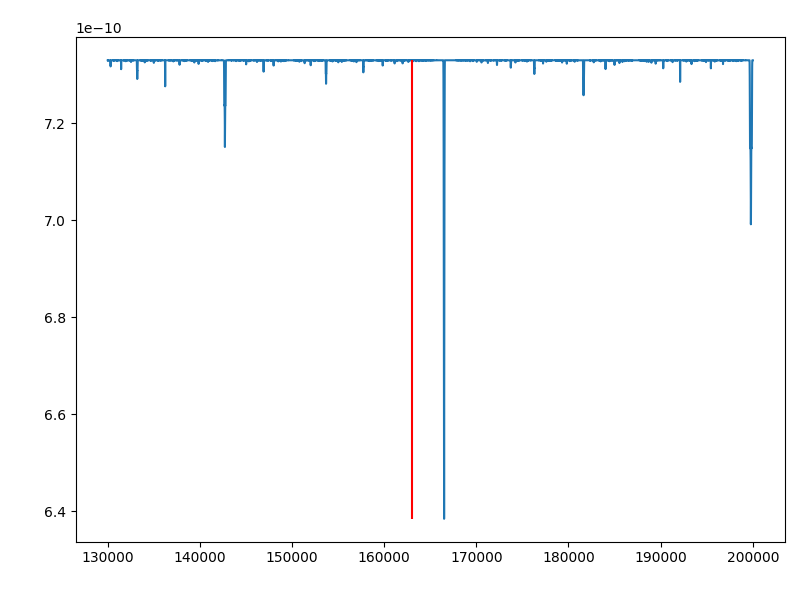

In [147]:
plt.clf()
plt.cla()
plt.plot(omega_vec,M_pump)
plt.vlines(x=163000, ymin = np.min(M_pump), ymax = np.max(M_pump), colors='r')
plt.show()

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

# Interactive plot function
def plot_oscillation(i):
    plt.figure(figsize=(8, 4))
    plt.plot(t_vec, results_raw[i, :])
    plt.xlabel("t (time)")
    plt.ylabel("M_pump(t)")
    plt.title(f"Oscillation at ω = {omega_vec[i]:.1f}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Slider from 0 → len(omega_vec)-1
interact(
    plot_oscillation,
    i=IntSlider(min=0, max=len(omega_vec)-1, step=1, value=0)
)


interactive(children=(IntSlider(value=0, description='i', max=999), Output()), _dom_classes=('widget-interact'…

<function __main__.plot_oscillation(i)>

## Absorption model

the absorption model is based on the theory from Scott J. Seltzer PhD thesis.

We start with the optical absorption from the following statement:
'Regardless of the form of the frequency response, the integral of the absorption cross-section associated with a given resonance is a constant:
$$\int_0^{+\infty} \sigma(\nu) d\nu = \pi r_e c f_{res}$$
where $r_e = 2.82 \times 10^{-15}m$ the classical electron radius[...]'

Is given later te profile of this cross section inthe case of the natural lifetime and pressure broadening :
$$\mathscr{L} (\nu - \nu_0) = \frac{\Gamma/2\pi}{(\nu - \nu_0)^2 + (\Gamma_L/2)^2}$$
Hence :
$$\sigma_L(\nu) = \pi r_e c f \mathscr{L}(\nu - \nu_0)$$

Assuming that we are at resonance, we have $\sigma(\nu_0) = \frac{2r_ecf}{\Gamma_L}$

Next step is the transmission:

$$\frac{d}{dz}I = -n\sigma(\nu)I (1-2s \langle S_z \rangle)$$
s being the light momentum ($\sigma^+$ gives s=+1, $\sigma^-$ gives s=-1, linear polarization gives s=0)

We assume that $2s\langle S_z \rangle = \langle M_{tot}(\omega_{RF}) \rangle$ MEGA FAUX

We assume that $M_{tot}$ doesn't change along z and we only vary $\omega_{RF}$. We thus have : 
$$I(z) = I_0 e^{-n \sigma(\nu_0)(1-M_{tot}\left(\omega_{RF})\right)z}$$
We are interested in z=l=1.5mm

In [ ]:
r_e = 2.82e-15 #m, classical electron radius
c = 299792458
f = 1/3

expectation_S_pump = M_pump_tot/(n*gamma)

S = -M_pump*hbar/(mu_B*2*n)

sigma_res = (2*r_e*c*f)/Gamma_natural
OD_M = n*sigma_res*(1-2*S)*z_cell
I_out = P_in*np.exp(-OD_M)

In [144]:
S

array([-2.71877372e-39, -2.71825274e-39, -2.71877445e-39, ...,
       -2.71877380e-39, -2.71877573e-39, -2.71877310e-39])

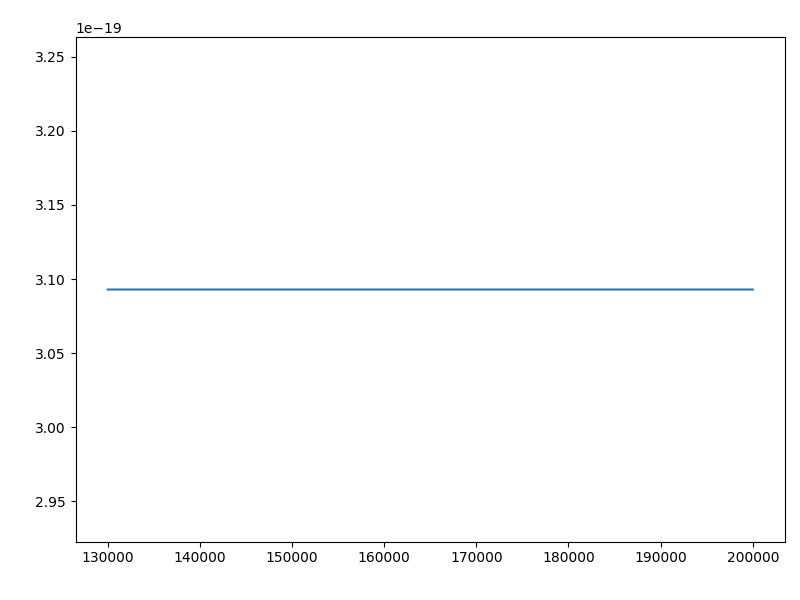

In [140]:
plt.clf()
plt.cla()
plt.plot(omega_vec,I_out)
plt.show()

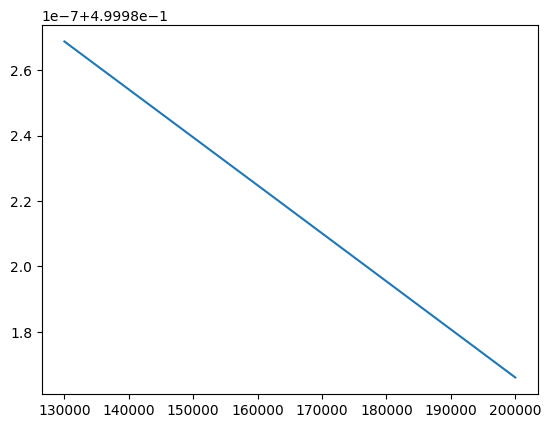

In [ ]:
plt.plot(omega M_pump_tot/M0)
plt.show()

In [77]:
np.std(M_pump_tot/M0)

np.float64(3.641619129533098e-05)

In [74]:
print(5e12*1e6)
print(n)

5e+18
1.5327315172833894e+18


In [57]:
print('FWHM = ',2*np.sqrt(Gamma_tot**2+2*delta**2))
print('$2\delta^2$', 2*delta**2)

FWHM =  12337.917166199488
$2\delta^2$ 13056050.0


In [65]:
np.std(T_tot)

np.float64(2.6506933179325453e-08)

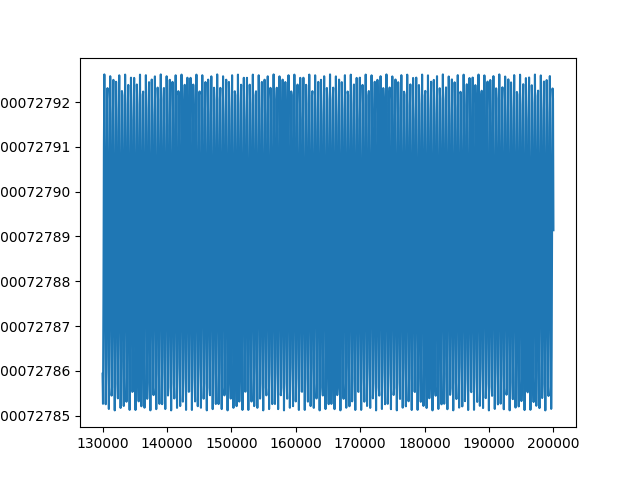

In [67]:
%matplotlib widget
plt.plot(omega, T_tot)
plt.show()

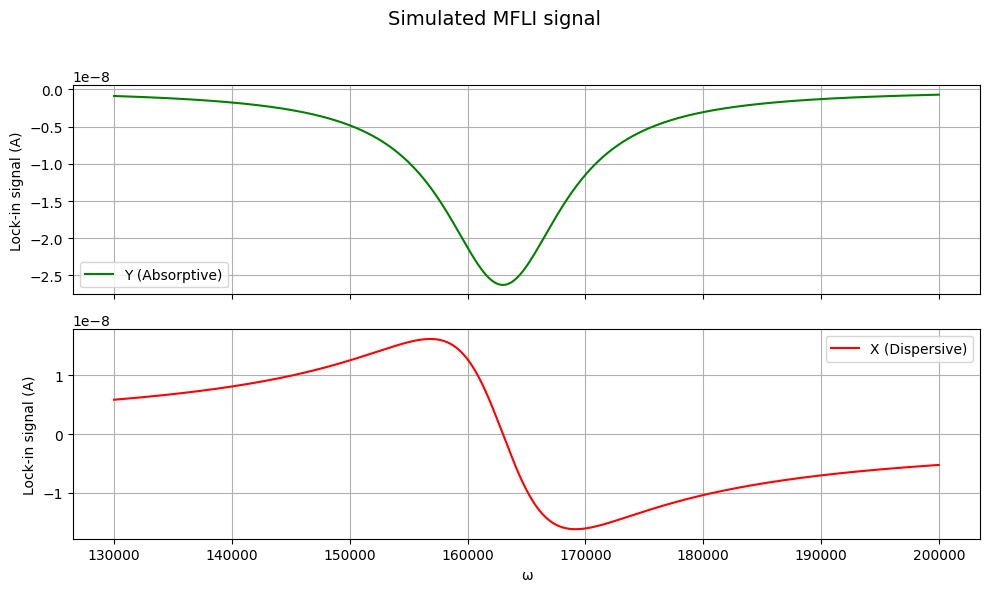

In [59]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# --- Top plot: Y_sim ---
ax[0].plot(omega, Y_sim, label='Y (Absorptive)', color='g')
ax[0].set_ylabel("Lock-in signal (A)")
ax[0].grid(True)
ax[0].legend()

# --- Bottom plot: X_sim ---
ax[1].plot(omega, X_sim, label='X (Dispersive)', color='r')
ax[1].set_xlabel("ω")
ax[1].set_ylabel("Lock-in signal (A)")
ax[1].grid(True)
ax[1].legend()

# Single shared title
fig.suptitle("Simulated MFLI signal", fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Actual data

Current Data

In [49]:
filename = 'odmr_data/ODMR_serf_130k_200k_X_Y_current_HT.txt'

df = pd.read_csv(filename, 
                   comment='%', 
                   sep=';', 
                   names=['freq', 'X/Y'])

freq = df['freq'][:len(df['freq'])//2]
X = df['X/Y'][:len(df['freq'])//2] 
Y = df['X/Y'][len(df['freq'])//2:] 

freq = np.array(freq)
X = np.array(X)
Y = np.array(Y)

In [50]:
# Basic Lorentzian
def lorentzian(f, A, f0, Gamma):
    return A * (0.5*Gamma)**2 / ((f - f0)**2 + (0.5*Gamma)**2)

# Fit a single Lorentzian in a frequency range
def fit_local_lorentzian(freq, amp, fmin, fmax):
    # select local range
    mask = (freq >= fmin) & (freq <= fmax)
    f_local = freq[mask]
    a_local = amp[mask]
    
    if len(f_local) == 0:
        return None, None
    
    # Initial guesses
    A0 = np.max(a_local) - np.min(a_local)
    f0_0 = f_local[np.argmax(a_local)]
    G0 = (fmax - fmin) / 10.0
    
    p0 = [A0, f0_0, G0]
    bounds = ([0, fmin, 1e-9], [np.inf, fmax, fmax-fmin])
    
    try:
        popt, pcov = curve_fit(lorentzian, f_local, a_local, p0=p0, bounds=bounds)
    except Exception as e:
        print("Fit failed in range", fmin, fmax, ":", e)
        return None, None
    
    return popt, pcov

def inverted_lorentzian(f, A, f0, Gamma, y0):
    """
    A: depth of the dip (positive number)
    f0: center frequency
    Gamma: full width at half maximum (FWHM)
    y0: baseline offset
    """
    return y0 - A * (0.5*Gamma)**2 / ((f - f0)**2 + (0.5*Gamma)**2)

# Fit a single inverted Lorentzian in a frequency range
def fit_local_inverted_lorentzian(freq, amp, fmin, fmax):
    # Convert to numpy arrays if needed
    freq = np.array(freq)
    amp = np.array(amp)

    mask = (freq >= fmin) & (freq <= fmax)
    f_local = freq[mask]
    a_local = amp[mask]

    if len(f_local) == 0:
        return None, None

    # Initial guesses
    A0 = np.max(a_local) - np.min(a_local)
    f0_0 = f_local[np.argmin(a_local)]
    G0 = (fmax - fmin) / 10.0
    y0_0 = np.max(a_local)

    p0 = [A0, f0_0, G0, y0_0]
    bounds = ([0, fmin, 1e-9, -np.inf], [np.inf, fmax, fmax-fmin, np.inf])

    try:
        popt, pcov = curve_fit(inverted_lorentzian, f_local, a_local, p0=p0, bounds=bounds)
    except Exception as e:
        print("Fit failed in range", fmin, fmax, ":", e)
        return None, None

    return popt, pcov

def dispersive(f, A, f0, Gamma, y0):
    d = f - f0
    return y0 + A * (d * (0.5*Gamma)) / (d**2 + (0.5*Gamma)**2)


def fit_local_dispersive(freq, amp, fmin, fmax):
    freq = np.array(freq)
    amp = np.array(amp)

    mask = (freq >= fmin) & (freq <= fmax)
    f_local = freq[mask]
    a_local = amp[mask]

    if len(f_local) == 0:
        return None, None

    # Initial guesses
    f0_guess = f_local[np.argmin(np.abs(a_local - np.mean(a_local)))]  # zero-crossing approx
    A0 = (np.max(a_local) - np.min(a_local))
    G0 = (fmax - fmin)/10
    y0_0 = np.mean(a_local)

    p0 = [A0, f0_guess, G0, y0_0]
    bounds = ([-np.inf, fmin, 1e-9, -np.inf],
              [ np.inf, fmax, (fmax-fmin),  np.inf])

    try:
        popt, pcov = curve_fit(dispersive, f_local, a_local, p0=p0, bounds=bounds)
    except Exception as e:
        print("Dispersive fit failed:", e)
        return None, None

    return popt, pcov


In [51]:
fit_ranges = [
    (freq[0],freq[-1])
]

local_fits = []

for fmin, fmax in fit_ranges:
    popt_L, pcov_L = fit_local_inverted_lorentzian(freq, Y, fmin, fmax)
    if popt_L is not None:
        local_fits.append({
            'fmin': fmin,
            'fmax': fmax,
            'popt_L': popt_L,
            'pcov_L': pcov_L
        })
        
dispersive_fits = []

for fmin, fmax in fit_ranges:   # same fit_ranges as your X fit
    popt_D, pcov_D = fit_local_dispersive(freq, X, fmin, fmax)
    if popt_D is not None:
        dispersive_fits.append({
            'fmin': fmin,
            'fmax': fmax,
            'popt_D': popt_D,
            'pcov_D': pcov_D
        })


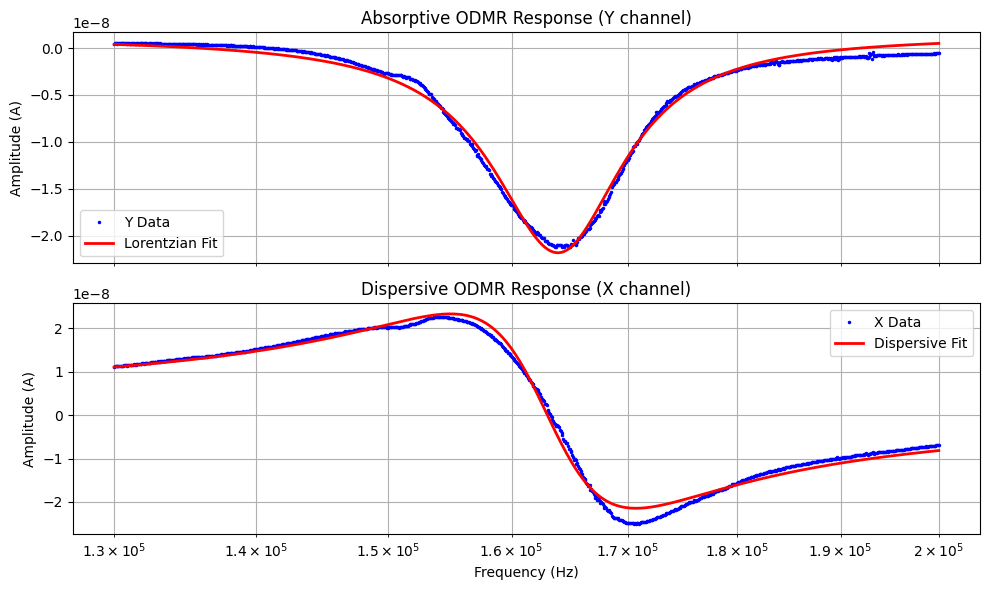


=== FIT RESULTS — Absorptive (X channel) ===
A_L      = 2.309e-08
f0_L     = 163913.967698 Hz
Gamma_L  = 13693.771961 Hz
y0_L     = 0.000000

=== FIT RESULTS — Dispersive (Y channel) ===
A_D      = -4.473e-08
f0_D     = 162854.698345 Hz
Gamma_D  = 15757.852230 Hz
y0_D     = 0.000000


In [52]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax[0].plot(freq, Y, 'b.', markersize=3, label="Y Data")

for fit in local_fits:
    fmin, fmax = fit['fmin'], fit['fmax']
    popt_L = fit['popt_L']
    f_fit = np.linspace(fmin, fmax, 300)
    y_fit = inverted_lorentzian(f_fit, *popt_L)
    ax[0].plot(f_fit, y_fit, 'r-', linewidth=2, label="Lorentzian Fit")

ax[0].set_title("Absorptive ODMR Response (Y channel)")
ax[0].set_ylabel("Amplitude (A)")
ax[0].grid(True, which = 'both')
ax[0].legend()

ax[1].plot(freq, X, 'b.', markersize=3, label="X Data")

for fit in dispersive_fits:
    fmin, fmax = fit['fmin'], fit['fmax']
    popt_D = fit['popt_D']
    f_plot = np.linspace(fmin, fmax, 300)
    x_fit = dispersive(f_plot, *popt_D)
    ax[1].plot(f_plot, x_fit, 'r-', linewidth=2, label="Dispersive Fit")

ax[1].set_title("Dispersive ODMR Response (X channel)")
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_ylabel("Amplitude (A)")
ax[1].grid(True, which='both')
ax[1].legend()


plt.xscale('log')   
plt.tight_layout()
plt.show()

A_L, f0_L, Gamma_L, y0_L = popt_L
A_D, f0_D, Gamma_D, y0_D = popt_D

print("\n=== FIT RESULTS — Absorptive (X channel) ===")
print(f"A_L      = {A_L:.4g}")
print(f"f0_L     = {f0_L:.6f} Hz")
print(f"Gamma_L  = {Gamma_L:.6f} Hz")
print(f"y0_L     = {y0_L:.6f}")

print("\n=== FIT RESULTS — Dispersive (Y channel) ===")
print(f"A_D      = {A_D:.4g}")
print(f"f0_D     = {f0_D:.6f} Hz")
print(f"Gamma_D  = {Gamma_D:.6f} Hz")
print(f"y0_D     = {y0_D:.6f}")

## Plot both

In [53]:
## Interpolate simulation onto the experimental frequency axis
X_sim_interp = np.interp(freq, omega, X_sim)
Y_sim_interp = np.interp(freq, omega, Y_sim)


## Restrict simulation to overlap region
mask_sim = (omega >= freq.min()) & (omega <= freq.max())

freq_sim_overlap = omega[mask_sim]
X_sim_overlap    = X_sim[mask_sim]
Y_sim_overlap    = Y_sim[mask_sim]

## Now interpolate simulation onto exp. frequencies
X_sim_interp = np.interp(freq, freq_sim_overlap, X_sim_overlap)
Y_sim_interp = np.interp(freq, freq_sim_overlap, Y_sim_overlap)


## Absorptive fit (inverted Lorentzian)
A_L, f0_L, Gamma_L, y0_L = local_fits[0]['popt_L']
X_fit = inverted_lorentzian(freq, A_L, f0_L, Gamma_L, y0_L)

## Dispersive fit
A_D, f0_D, Gamma_D, y0_D = dispersive_fits[0]['popt_D']
Y_fit = dispersive(freq, A_D, f0_D, Gamma_D, y0_D)


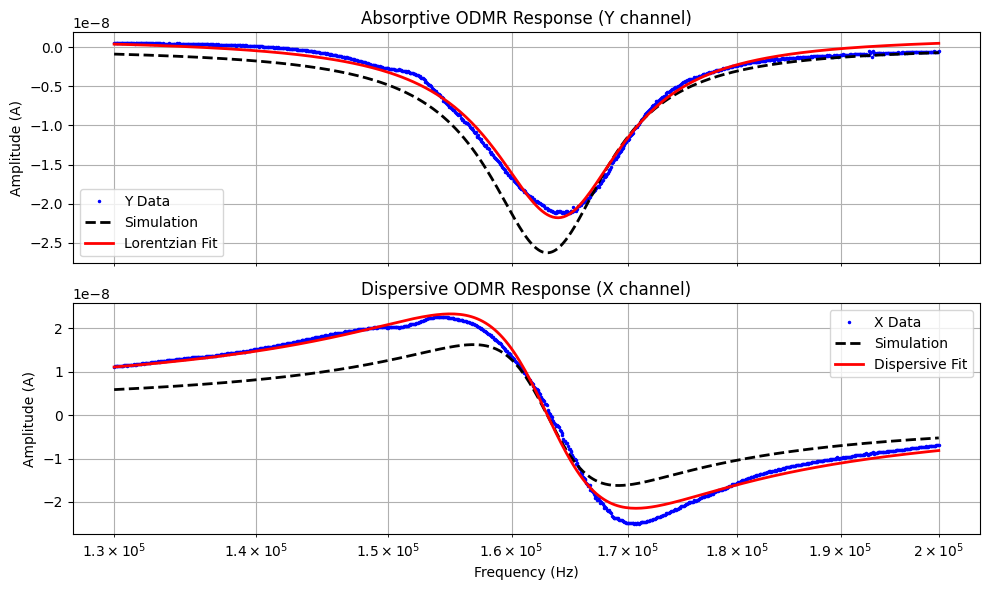

In [54]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax[0].plot(freq, Y, 'b.', markersize=3, label="Y Data")
ax[0].plot(freq, Y_sim_interp, 'k--', linewidth=2, label="Simulation")

for fit in local_fits:
    fmin, fmax = fit['fmin'], fit['fmax']
    popt_L = fit['popt_L']
    f_fit = np.linspace(fmin, fmax, 300)
    y_fit = inverted_lorentzian(f_fit, *popt_L)
    ax[0].plot(f_fit, y_fit, 'r-', linewidth=2, label="Lorentzian Fit")

ax[0].set_title("Absorptive ODMR Response (Y channel)")
ax[0].set_ylabel("Amplitude (A)")
ax[0].grid(True, which = 'both')
ax[0].legend()

ax[1].plot(freq, X, 'b.', markersize=3, label="X Data")
ax[1].plot(freq, X_sim_interp, 'k--', linewidth=2, label="Simulation")



for fit in dispersive_fits:
    fmin, fmax = fit['fmin'], fit['fmax']
    popt_D = fit['popt_D']
    f_plot = np.linspace(fmin, fmax, 300)
    x_fit = dispersive(f_plot, *popt_D)
    ax[1].plot(f_plot, x_fit, 'r-', linewidth=2, label="Dispersive Fit")

ax[1].set_title("Dispersive ODMR Response (X channel)")
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_ylabel("Amplitude (A)")
ax[1].grid(True, which='both')
ax[1].legend()


plt.xscale('log')   
plt.tight_layout()
plt.show()